In [1]:
import numpy as np
import pandas
from neuroanalysis.data import Recording, TSeries
from neuroanalysis.test_pulse import PatchClampTestPulse
from neuroanalysis.neuronsim.model_cell import ModelCell
from neuroanalysis.units import pA, mV, MOhm, pF, us, ms

In [2]:
model_cell = ModelCell()

In [3]:


def test_test_pulse():
    # Just test against a simple R/C circuit attached to a pipette
    model_cell.enable_mechs(['leak'])
    model_cell.recording_noise = False
    
    tp = create_test_pulse(pamp=-10*pA, mode='ic', r_access=100*MOhm)    
    check_analysis(tp, model_cell)
    
    
    
def create_test_pulse(start=5*ms, pdur=10*ms, pamp=-10*pA, mode='ic', dt=10*us, r_access=10*MOhm, noise=5*pA):
    # update patch pipette access resistance
    model_cell.clamp.ra = r_access
    
    # update noise amplitude
    model_cell.mechs['noise'].stdev = noise
    
    # make pulse array
    duration = start + pdur * 3
    pulse = np.zeros(int(duration / dt))
    pstart = int(start / dt)
    pstop = pstart + int(pdur / dt)
    pulse[pstart:pstop] = pamp
    
    # simulate response
    result = model_cell.test(TSeries(pulse, dt), mode)
    
    # generate a PatchClampTestPulse to test against
    tp = PatchClampTestPulse(result)
    for ch in tp.channels:
        tp[ch].t0 =0

    return tp


def expected_testpulse_values(cell):
    if cell.clamp.mode == 'ic':
        values = {
            'baseline_potential': model_cell.resting_potential(),
            'baseline_current': model_cell.clamp.holding['ic'],
            'access_resistance': model_cell.clamp.ra,
            'capacitance': model_cell.soma.cap,
        }
    else:
        values = {
            'baseline_potential': model_cell.clamp.holding['vc'],
            'baseline_current': model_cell.resting_current(),
            'access_resistance': model_cell.clamp.ra,
            'capacitance': None,
        }
    values['input_resistance'] = model_cell.input_resistance()

    return values


def check_analysis(tp, cell):
    measured = tp.analysis
    expected = expected_testpulse_values(cell)
    
    # how much error should we tolerate for each parameter?
    err_tolerance = {
        'baseline_potential': 0.01,
        'baseline_current': 0.01,
        'access_resistance': 0.3,
        'input_resistance': 0.1,
        'capacitance': 0.3,
    }
    
    for k,v1 in expected.items():
        v2 = measured[k]
        if v1 is None:
            assert v2 is None
            continue
        err = abs((v1 - v2) / v2)
        if err > err_tolerance[k]:
            raise ValueError("Test pulse metric out of range: %s = %g != %g"
                "  (err %g > %g)" % (k, v2, v1, err, err_tolerance[k]))



In [16]:
import matplotlib.pyplot as plt

# Just test against a simple R/C circuit attached to a pipette
model_cell.enable_mechs(['leak'])
model_cell.recording_noise = False

tp = create_test_pulse(pamp=-10*pA, mode='ic', r_access=10*MOhm)
tp.data.t0 = 0
tp._analyze()

name, units = ('pipette potential', 'V') if tp.clamp_mode == 'ic' else ('pipette current', 'A')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax in axes:
    ax.plot(tp['primary'].time_values, tp['primary'].data, label='primary')
    ax.plot(tp.initial_fit_trace.time_values, tp.initial_fit_trace.data, 'g', label='initial fit')
    ax.plot(tp.fit_trace.time_values, tp.fit_trace.data, 'r', label='final fit')
    ax.set_xlabel('time (s)')
    ax.set_ylabel(name + ' (' + units + ')')
    ax.legend()

# plot an expanded region near the pulse start
pstart = tp['primary'].t0 + tp.stimulus.start_time
axes[1].set_xlim(pstart - .1*ms, pstart + .3*ms)
axes[1].set_ylim(-.0755, -.0749)


# check_analysis(tp, model_cell)

# print("Vm %g mV    Rm %g MOhm" % (model_cell.resting_potential()*1000, model_cell.input_resistance()/1e6))

# # Have to test VC with very low access resistance
# tp = create_test_pulse(pamp=-10*mV, mode='vc', r_access=15*MOhm)
# tp.plot()

check_analysis(tp, model_cell)
print("Test passed")

df = pandas.DataFrame()
for k,v in expected_testpulse_values(model_cell).items():
    df[k] = [v, tp.analysis[k]]
# label df rows
df.index = ['IC expected', 'IC measured']
df


AttributeError: 'method' object has no attribute 't0'

In [7]:
check_analysis(tp, model_cell)
print("Test passed")

Test passed


/tmp/ipykernel_289874/1591168962.py:72: RuntimeWarning: invalid value encountered in scalar divide
  err = abs((v1 - v2) / v2)


(array([-3.86835159e-10,  1.00000000e-05,  9.28483000e+00]), array([[ 1.44843628e-21,  2.85194329e-17, -5.64202959e-26],
       [ 2.85194329e-17,  4.71274516e-12, -1.11094692e-21],
       [-5.64202959e-26, -1.11094692e-21,  2.19771476e-30]]))


,baseline_potential,baseline_current,access_resistance,capacitance,input_resistance
IC expected,-0.075,0.0,1.000000e+07,None,2.000000e+08
IC measured,-0.075,0.0,2.389905e+07,None,2.100200e+08


/tmp/ipykernel_289874/1591168962.py:72: RuntimeWarning: invalid value encountered in scalar divide
  err = abs((v1 - v2) / v2)


ValueError: Test pulse metric out of range: access_resistance = 2.38991e+07 != 1e+07  (err 0.581573 > 0.3)

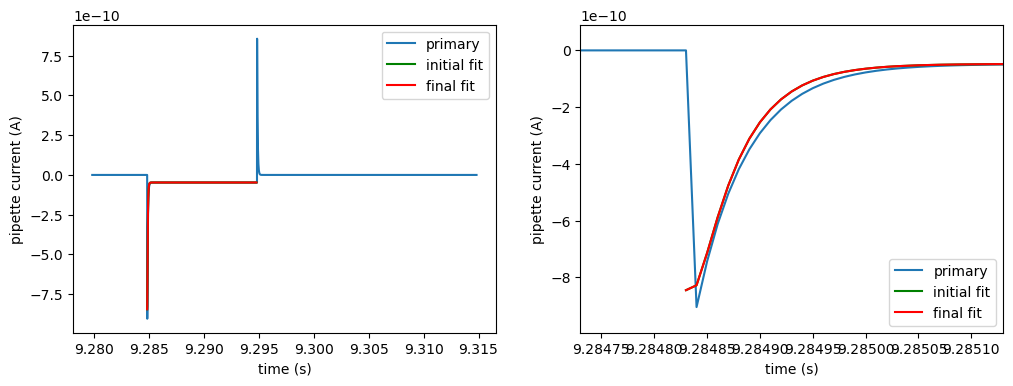

In [15]:
# Just test against a simple R/C circuit attached to a pipette
model_cell.enable_mechs(['leak'])
model_cell.recording_noise = False

tp = create_test_pulse(pamp=-10*mV, mode='vc', r_access=10*MOhm)
tp._analyze()

name, units = ('pipette potential', 'V') if tp.clamp_mode == 'ic' else ('pipette current', 'A')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax in axes:
    ax.plot(tp['primary'].time_values, tp['primary'].data, label='primary')
    ax.plot(tp.initial_fit_trace.time_values, tp.initial_fit_trace.data, 'g', label='initial fit')
    ax.plot(tp.fit_trace.time_values, tp.fit_trace.data, 'r', label='final fit')
    ax.set_xlabel('time (s)')
    ax.set_ylabel(name + ' (' + units + ')')
    ax.legend()

# plot an expanded region near the pulse start
pstart = tp['primary'].t0 + tp.stimulus.start_time
axes[1].set_xlim(pstart - .1*ms, pstart + .3*ms)
rgn = tp['primary'].time_slice(pstart - .1*ms, pstart + .3*ms)
mnmax = rgn.data.min(), rgn.data.max()
axes[1].set_ylim(mnmax[0] - 0.1*(mnmax[1]-mnmax[0]), mnmax[1] + 0.1*(mnmax[1]-mnmax[0]))


df = pandas.DataFrame()
for k,v in expected_testpulse_values(model_cell).items():
    df[k] = [v, tp.analysis[k]]
# label df rows
df.index = ['IC expected', 'IC measured']
display(df)

check_analysis(tp, model_cell)
print("Test passed")
